In [130]:
# Imports

import pickle
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

from deployml.keras import NeuralNetworkBase


from model_tools_class import mt

In [115]:
#Changing the option of the number of columns that is shown when looking at the DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [140]:
df = pd.read_csv(r'../data/train.csv')
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [117]:
# Reading in and cleaning the data



def wrangle(df):
    '''
    This function wranlges/prepares the data for usage in the model.
    '''

    # The daily price of the AirBnb listing.
    df['price'] = df['log_price'].apply(lambda x : round(np.exp(x)))

    # Cleaning the amenities column.
    df['amenities'] = df['amenities'].apply(mt.clean)
    df['amenities'] = df['amenities'].apply(lambda x: len(x))

    # Applying the get_days function to create a new feature = total number of hosted days.
    df['host_since_days'] = df['host_since'].apply(mt.get_days)

    # Dropping redundant columns.
    df.drop(columns=['host_since','log_price','id','latitude','longitude','name','description','thumbnail_url','review_scores_rating','number_of_reviews','host_has_profile_pic','host_response_rate','last_review','first_review'],inplace=True)

    # A new column: Is the room isntantly bookable.
    df['instant_bookable'].replace(('f','t'),("False",'True'),inplace=True)

    # A new column: is the hosts' identity verified.
    df['host_identity_verified'].replace(('f','t'),("False",'True'),inplace=True)

    # Dropping null values
    df = df.dropna(axis=0)
    
    return df

df = wrangle(df)

In [118]:
# Splitting the data
Y = df['price']
X = df.drop(columns=['price'])

# moving price to the back of df
df['target/price'] = df['price']
df.drop(columns=['price'],inplace=True)

In [119]:
X_strings = X.select_dtypes(include='object')
X_non_strings = X.select_dtypes(include=['int64','float'])
oe =OrdinalEncoder()
oe.fit(X_strings)
X_train = oe.transform(X_strings)

In [120]:
X_train_whole = np.concatenate((X_train,X_non_strings),axis=1)

model_columns = X_strings.columns.append(X_non_strings.columns)

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X_train_whole,Y,test_size=0.3,random_state=42)

In [122]:
# Instantiating the model
model = Sequential()

model.add(Dense(1024, input_dim = X_train_whole.shape[1]))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256,))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(LeakyReLU(alpha=0.05))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation="linear"))

model.compile(optimizer=Adam(lr=0.005, decay=5e-4), loss='mse')

C:\Users\justi\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [123]:
checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

history = model.fit(x=X_train,y=y_train.values,
            validation_data=(X_val,y_val.values),
            batch_size=128,epochs=150, callbacks=callbacks_list)

Epoch 1/150
362/362 [==============================] - 7s 17ms/step - loss: 25266.4707 - val_loss: 26945.2715

Epoch 00001: val_loss improved from inf to 26945.27148, saving model to Weights\Weights-001--26945.27148.hdf5
Epoch 2/150
362/362 [==============================] - 6s 17ms/step - loss: 19762.8945 - val_loss: 28497.2227

Epoch 00002: val_loss did not improve from 26945.27148
Epoch 3/150
362/362 [==============================] - 6s 17ms/step - loss: 18996.5430 - val_loss: 28560.5527

Epoch 00003: val_loss did not improve from 26945.27148
Epoch 4/150
362/362 [==============================] - 6s 17ms/step - loss: 18760.1855 - val_loss: 23604.9941

Epoch 00004: val_loss improved from 26945.27148 to 23604.99414, saving model to Weights\Weights-004--23604.99414.hdf5
Epoch 5/150
362/362 [==============================] - 6s 17ms/step - loss: 18225.7559 - val_loss: 20051.0195

Epoch 00005: val_loss improved from 23604.99414 to 20051.01953, saving model to Weights\Weights-005--20051.

<AxesSubplot:>

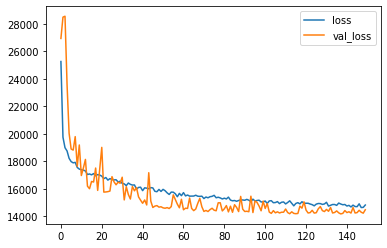

In [124]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [125]:
predictions = model.predict(X_val)

In [126]:
mean_absolute_error(y_val,predictions)

57.9709095675533

In [141]:
model.save('Airbnb_models')

INFO:tensorflow:Assets written to: Airbnb_models\assets


In [142]:
import pickle

In [143]:
file = open('my_pickle_model', 'wb')
